# SI 618 Homework 8 - Improving LDA

## Objectives
* to gain practical experience with NLP techniques
* to be exposed to loading large datasets via AWS S3 and parquet format

## Please fill in...
### * Your name: Raphael Ku
### * People you worked with:  I worked by myself

## Submission Instructions:
Please turn in your completed Databricks notebook in HTML format as well as the URL to the published version of your completed notebook.

## Assignment Instructions:
In this week's lab, we investigated the use of latent Dirichilet allocation (LDA) to analyze text.
In particular, we applied LDA to the Enron Corp. email data.  In this homework assignment we
are going to ask you to revisit the Enron LDA analysis and try to improve it.  

Recall that LDA seeks to extract a number of topics (the number is supplied by you) from a 
collection of documents. Each one of those topics can be described by the words that are most closely
associated with it and thereby facilitate the interpretation of the topic.  
For example, a topic that is most closely associated with the words blue, green, 
yellow, red, and purple might be interpreted as being about "colors".  That's an ideal
example.  In practice, the words that are associated with the topics often don't lead us to 
an easy interpretation of the topic.  In some cases, we can improve the interpretability of
the topics.  

For example, we can manipulate the model parameters (e.g. changing the number of topics) or
we can try to do a better job of cleaning the data before analyzing it.  We can experiment
with the inclusion or exclusion of stopwords.  Or we can get very creative and use bigrams or
trigrams instead of unigrams (words) in our analysis.

This homework assignment provides you with an oppportunity to improve the LDA we performed on
the Enron data, which is reproduced below.  To start this lab, run the cells below and examine the
output. Describe the topics and comment on the quality and/or interpretability of the topics. Then, follow the steps below to apply some of the techniques mentioned above.
 
One measure of the "goodness" of a topic model is the interpretability of the topics.  That is,
do the words associated with the topic form a coherent set (like the colors example above) or
are the seemingly random words?

You will notice that we're using a 1% sample of the email corpus (note the ```sample(0.01)``` function). Another measure of the "goodness" of a topic model is the stability of the model over different random samples.  
What happens to your topics when you re-run the analysis (thereby sampling a differnt 1%).  What happens when you
run your analysis on the complete email corpus?

There are also two numerical measures of model goodness that are available:  log(perplexity) and log(likelihood).
Lower values of log(perplexity) are better, whereas higher values of log(likelihood) are generally
considered better.   You can use these "objective" measures in combination with the "subjective" assessments of 
the interpretability of topics when assessing your model.

This assignment is worth a total of 80 points.  You will receive up to 16 points for each of the following 4 improvements:
1. Vary the number of topics from 6 to 12 (i.e. 6, 7, 8, 9, 10, 11, and 12).  Which value(s) gives you the "best" solution?  What criteria did you use for determining how good each solution is? 
2. How does the topic model change if you include or exclude stopwords? What's the best way to deal with non-alpha characters (e.g. numbers)? Is it better to include or exclude stopwords?  Use the "better" version in subsequent steps.
3. Clean the text from the body of each email message by excluding the "quoted replies" (i.e. the copy of the original message
that is often included in a reply).  How do the results of your topic model change? (Note: you might want to use RDDs and regular expressions for part of this analysis.)
4. Given the model from the "best" number of topics from Step 1, the best choice of including or excluding stopwords, 
and using cleaned email bodies, how consistent/stable are the topics from 
multiple runs (i.e. using different 1% samples)?  How do you define consistency and stability?

For each improvement, you will be assessed on:

1. the clarity of your code (both in terms of programming aspects such as variable names and in terms of Markdown cells explaining what you did),
2. the completeness of your interpretations, and
3. the quality of the presentation of your results (e.g. using tables and/or visualizations as appropriate).

### Above and Beyond
Select one of the following options for up to 16 points:
1. Use LDA to create two additional topic models based on (1) bigrams and (2) trigrams.  Find the best number of topics, determine whether to include
stopwords, and clean the email bodies.  How do these topics compare with the ones from the unigram analysis above in terms of interpretability and stability?
2. In the cell below, the LDA model of the enron DataFrame is stored in a DataFrame called ```enron_lda```.  If you examine that DataFrame you will notice a column called ```topicDistribution```, which tells you the proportion of each topic that makes up each document.  For each document (i.e. row in ```enron_lda```), figure out which topic is the dominant one and label that document as belonging to that topic.  So, for example, if you 
have a 6-topic model and see
```
topicDistribution=DenseVector([0.011, 0.0114, 0.9446, 0.0111, 0.011, 0.0109]
```
for a document, you would label that document as topic "3" because the largest number (0.9446) is associated with topic #3.  Based on this approach, report the number of documents that are labelled with each topic number.

### End of instructions... code follows

In [2]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer 
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.ml.pipeline import Pipeline
import numpy as np
import nltk
nltk.download("book")

[nltk_data] Downloading collection 'book'
[nltk_data] | 
[nltk_data] | Downloading package abc to /root/nltk_data...
[nltk_data] | Package abc is already up-to-date!
[nltk_data] | Downloading package brown to /root/nltk_data...
[nltk_data] | Package brown is already up-to-date!
[nltk_data] | Downloading package chat80 to /root/nltk_data...
[nltk_data] | Package chat80 is already up-to-date!
[nltk_data] | Downloading package cmudict to /root/nltk_data...
[nltk_data] | Package cmudict is already up-to-date!
[nltk_data] | Downloading package conll2000 to /root/nltk_data...
[nltk_data] | Package conll2000 is already up-to-date!
[nltk_data] | Downloading package conll2002 to /root/nltk_data...
[nltk_data] | Package conll2002 is already up-to-date!
[nltk_data] | Downloading package dependency_treebank to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package dependency_treebank is already up-to-date!
[nltk_data] | Downloading package genesis to /root/nltk_data...
[nltk_data] | Package genesis is already up-to-date!
[nltk_data] | Downloading package gutenberg to /root/nltk_data...
[nltk_data] | Package gutenberg is already up-to-date!
[nltk_data] | Downloading package ieer to /root/nltk_data...
[nltk_data] | Package ieer is already up-to-date!
[nltk_data] | Downloading package inaugural to /root/nltk_data...
[nltk_data] | Package inaugural is already up-to-date!
[nltk_data] | Downloading package movie_reviews to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package movie_reviews is already up-to-date!
[nltk_data] | Downloading package nps_chat to /root/nltk_data...
[nltk_data] | Package nps_chat is already up-to-date!
[nltk_data] | Downloading package names to /root/nltk_data...
[nltk_data] | Package names is already up-to-date!
[nltk_data] | Downloading package ppattach to /root/nltk_data...
[nltk_data] | Package ppattach is already up-to-date!
[nltk_data] | Downloading package reuters to /root/nltk_data...
[nltk_data] | Package reuters is already up-to-date!
[nltk_data] | Downloading package senseval to /root/nltk_data...
[nltk_data] | Package senseval is already up-to-date!
[nltk_data] | Downloading package state_union to /root/nltk_data...
[nltk_data] | Package state_union is already up-to-date!
[nltk_data] | Downloading package stopwords to /root/nltk_data...
[nltk_data] | Package stopwords is already up-to-date!
[nltk_data] | Downloading package swadesh to /root/nltk_data...
[nltk_data] | Package swadesh is already up-to-date!
[nltk_data] | Downloading package timit to /root/nltk_data...
[nltk_data] | Package timit is already up-to-date!
[nltk_data] | Downloading package treebank to /root/nltk_data...
[nltk_data] | Package treebank is already up-to-date!
[nltk_data] | Downloading package toolbox to /root/nltk_data...
[nltk_data] | Package toolbox is already up-to-date!
[nltk_data] | Downloading package udhr to /root/nltk_data...
[nltk_data] | Package udhr is already up-to-date!
[nltk_data] | Downloading package udhr2 to /root/nltk_data...
[nltk_data] | Package udhr2 is already up-to-date!
[nltk_data] | Downloading package unicode_samples to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package unicode_samples is already up-to-date!
[nltk_data] | Downloading package webtext to /root/nltk_data...
[nltk_data] | Package webtext is already up-to-date!
[nltk_data] | Downloading package wordnet to /root/nltk_data...
[nltk_data] | Package wordnet is already up-to-date!
[nltk_data] | Downloading package wordnet_ic to /root/nltk_data...
[nltk_data] | Package wordnet_ic is already up-to-date!
[nltk_data] | Downloading package words to /root/nltk_data...
[nltk_data] | Package words is already up-to-date!
[nltk_data] | Downloading package maxent_treebank_pos_tagger to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package maxent_treebank_pos_tagger is already up-
[nltk_data] | to-date!
[nltk_data] | Downloading package maxent_ne_chunker to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package maxent_ne_chunker is already up-to-date!
[nlt

In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltkstopwords

In [4]:
# This allows us to use the S3 bucket as a directory containing the data file(s)
ACCESS_KEY = ""
SECRET_KEY = ""
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = ""
MOUNT_NAME = ""
try:
  dbutils.fs.unmount("/mnt/%s/" % MOUNT_NAME)
except:
  print("Could not unmount %s, but that's ok." % MOUNT_NAME)
dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
#display(dbutils.fs.ls("/mnt/umsi-data-science/si618wn2017"))

/mnt/umsi-data-science/ has been unmounted.
 Out[ 220 ]: True

In [5]:
# This is a helper function that looks up the words associated with indices.  
# It's used below.
from pyspark.sql.types import ArrayType, StringType

def indices_to_terms(vocabulary):
    def indices_to_terms(xs):
        return [vocabulary[int(x)] for x in xs]
    return udf(indices_to_terms, ArrayType(StringType()))

In [6]:
# The next line loads the Enron email dataset from parquet format.  For details, see
# https://spark.apache.org/docs/latest/sql-programming-guide.html#parquet-files
# Note the following line takes a sample of approximately 1% of the rows
enron = spark.read.parquet("/mnt/umsi-data-science/si618wn2017/mail.parquet").sample(False,0.01)

In [7]:
# This cell is a complete machine learning pipeline to run LDA on a dataset
# Note that you might want to split this up into individual cells for
# your assignment.  

k = 6 # set the number of topics to extract

tokenizer = Tokenizer(inputCol="body", outputCol="words")

stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
stopWordsRemover.loadDefaultStopWords("english")

vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", minDF=2) 

print ("k = ",k)
lda = LDA(k=6, maxIter=10)

pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, vectorizer, lda])
pipelineModel = pipeline.fit(enron)

countVectorModel = pipelineModel.stages[-2]
cmv = countVectorModel.vocabulary
print("Vocab length is",len(cmv))

ldaModel = pipelineModel.stages[-1]

# Assess the model
enron_lda = pipelineModel.transform(enron)

lp = ldaModel.logPerplexity(enron_lda)
print("Log perplexity  (lower is better): ",lp)
ll = ldaModel.logLikelihood(enron_lda)
print("Log likelihood (higher is better): ",ll)
# Describe topics.

topics = ldaModel.describeTopics(8)

topics = topics.withColumn(
    "topicWords", indices_to_terms(countVectorModel.vocabulary)("termIndices"))
topics.select("topicWords").show(10,truncate=False)


k = 6
Vocab length is 42848
Log perplexity (lower is better): 6.618557579796248
Log likelihood (higher is better): -8892678.562574387
+--------------------------------------------------------------------------------------------+
topicWords |
+--------------------------------------------------------------------------------------------+
[, =09=09, ab, to:, subject:, -, cc:, enron] |
[class=td2, <tr, ><td, ><a, size=1>updated, face="arial,, helvetica"><font, bgcolor=#eaeaea]|
[>, , virus, pnm, western, task, football., k] |
[, >, -, to:, subject:, enron, pm, please] |
[database, attempting, occurred, engine, (error, !!!an, $2a04), initialize] |
[, please, -, to:, subject:, *, let, know] |
+--------------------------------------------------------------------------------------------+

### Question 1
As part of the problem, to easily modify the number of topics, I converted the LDA process into a function. The criteria I plan to use to evaluate the groupings would be on log likelihood, and interpretability of the topics.


Based on the 1% sample chosen, the best number of topics seem to be k=9, as seen in <a href='https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3809935650681397'>Cmd 13</a>, given a log likelihood not too far from the lowest of the modeled (-8.9M for k=9 vs. the lowest log likelihood of -8.81M for k=7), as well as stronger groupings of words for database issues (topic 1), concerns on business in certain states (topic 5), and grouping words with similar structure (management-*) in topic 2.

In [9]:
### LDA (function so k is easily modified)
def LDAfunc(kval, data):
  tokenizer = Tokenizer(inputCol="body", outputCol="words")

  stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
  stopWordsRemover.loadDefaultStopWords("english")

  vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", minDF=2) 
  
  lda = LDA(k=kval, maxIter=10)
  pipeline = Pipeline(stages=[tokenizer, stopWordsRemover, vectorizer, lda])
  pipelineModel = pipeline.fit(data)
  
  countVectorModel = pipelineModel.stages[-2]
  cmv = countVectorModel.vocabulary
  print("Vocab length is",len(cmv))
  
  ldaModel = pipelineModel.stages[-1]
  enron_lda = pipelineModel.transform(data)
  
  lp = ldaModel.logPerplexity(enron_lda)
  print("Log perplexity  (lower is better): ",lp)
  ll = ldaModel.logLikelihood(enron_lda)
  print("Log likelihood (higher is better): ",ll)
  # Describe topics.

  topics = ldaModel.describeTopics(8)

  topics = topics.withColumn(
    "topicWords", indices_to_terms(countVectorModel.vocabulary)("termIndices"))
  topics.select("topicWords").show(20,truncate=False)
  
  return enron_lda

In [10]:
LDAfunc(6, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.616924319668698
Log likelihood (higher is better): -8890474.313496111
+---------------------------------------------------------------------+
topicWords |
+---------------------------------------------------------------------+
[, database, error, attempting, occurred, engine, initialize, (error]|
[tax), (enw), (eel), (ena), (isc), (corp), (corp, (enw] |
[>, class=td2, , ><td, 25mw, 9/30, size=1>updated, ><a] |
[, >, -, to:, subject:, enron, pm, please] |
[>, , (e-mail);, virus, state, to:, please, desktop] |
[, class=td2, variances, hourahead, final, ----, hour:, -] |
+---------------------------------------------------------------------+

 Out[ 225 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

In [11]:
LDAfunc(7, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.558330561255335
Log likelihood (higher is better): -8811753.526933689
+----------------------------------------------------------------------------+
topicWords |
+----------------------------------------------------------------------------+
[, -, power, subject:, to:, gas, day's, =] |
[(enw), tax), (eel), (ena), (isc), (corp), (corp, (enw] |
[>, class=td2, , <tr, ><td, ><a, helvetica"><font, size=1>updated] |
[, >, -, pm, to:, subject:, please, =] |
[database, borland, occurred, attempting, (error, !!!an, engine, initialize]|
[, please, -, =20, ,, following, group, <<<>>>] |
[, enron, new, -, to:, subject:, please, =20] |
+----------------------------------------------------------------------------+

 Out[ 226 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

In [12]:
LDAfunc(8, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.610637768387907
Log likelihood (higher is better): -8882033.77218961
+--------------------------------------------------------------------------------------------+
topicWords |
+--------------------------------------------------------------------------------------------+
[, -, subject:, to:, cc:, enron, following, pm] |
[class=td2, ><td, <tr, helvetica"><font, size=1>updated, ><a, face="arial,, bgcolor=#eaeaea]|
[(enw), tax), (ena), (isc), (eel), (corp), (corp, (enw] |
[, >, -, to:, pm, subject:, =20, cc:] |
[, energy, state, williams, 7, please, news, live] |
[, =20, please, ab, *, committee, <<<>>>, may] |
[, enron, new, said, please, company, to:, -] |
[database, $2a04), borland, engine, !!!an, occurred, (error, initialize] |
+--------------------------------------------------------------------------------------------+

 Out[ 227 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

In [13]:
LDAfunc(9, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.635198078097851
Log likelihood (higher is better): -8915032.758847129
+----------------------------------------------------------------------------------------------------------------+
topicWords |
+----------------------------------------------------------------------------------------------------------------+
[, database, error, engine, (error, !!!an, occurred, initialize] |
[1/17/01, eff_dt, management-pwr, management-coal, management-gas, management-crd, portfolio_id, agg-management]|
[class=td2, ><td, ><a, helvetica"><font, <tr, size=1>updated, face="arial,, bgcolor=#f0f0f0] |
[, >, -, pm, to:, subject:, =, please] |
[, state, tax), energy, power, please, contracts, (enw)] |
[, ,, power, -, to:, said, may, gas] |
[, enron, -, to:, subject:, =20, please, new] |
[>, (enw), tax), , (ena), (eel), (isc), (corp)] |
[<<<>>>, 25mw, 9/30, , helvetica,, size="3", cellspacing="0", color="#ffcc33"><font] |
+----------------------------------------------------------------------------------------------------------------+

 Out[ 228 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

In [14]:
LDAfunc(10, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.711788345946857
Log likelihood (higher is better): -9017939.86926176
+----------------------------------------------------------------------------+
topicWords |
+----------------------------------------------------------------------------+
[, energy, ab, power, gas, iep, shows, enron] |
[, like,, back?, production, may, anything, similar, call] |
[, nyiso, technical, 1/17/01, -, market, eff_dt, comment] |
[, >, -, to:, pm, subject:, please, cc:] |
[database, initialize, !!!an, occurred, (error, attempting, engine, borland]|
[, *, ,, please, -, following, to:, subject:] |
[, =20, enron, -, new, please, to:, said] |
[>, , virus, pnm, western, 1,, miller, virtual] |
[(enw), class=td2, tax), (eel), (ena), (isc), ><td, (corp)] |
[, dog, odor, pet, deborah;, got, hunt, like] |
+----------------------------------------------------------------------------+

 Out[ 229 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

In [15]:
LDAfunc(11, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.77126280819587
Log likelihood (higher is better): -9097851.873196024
+---------------------------------------------------------------------------------------+
topicWords |
+---------------------------------------------------------------------------------------+
[, to:, subject:, cc:, power, -, state, energy] |
[(enw), tax), (ena), (eel), (isc), (corp), (corp, (enw] |
[, ok, michelle, 9:13, along, counsel, sent, subject:] |
[, >, -, to:, subject:, pm, please, cc:] |
[database, error, occurred, (error, $2a04), !!!an, borland, initialize] |
[, ,, please, to:, subject:, <<<>>>, may, -] |
[, said, enron, =20, new, -, power, million] |
[>, , virus, 1/17/01, gas, miller, virtual, k] |
[, shows, 50mw, 25mw, deal, trailing, 6600, desktop] |
[1,, size="3", cellspacing="0", , helvetica,, color="#ffcc33"><font, <tr, width="100%"]|
[class=td2, ><td, <tr, helvetica"><font, size=1>updated, ><a, bgcolor=#eaeaea, yards] |
+---------------------------------------------------------------------------------------+

 Out[ 230 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

In [16]:
LDAfunc(12, enron)

Vocab length is 42848
Log perplexity (lower is better): 6.847568457432971
Log likelihood (higher is better): -9200372.077699972
+--------------------------------------------------------------------------------------------------------------+
topicWords |
+--------------------------------------------------------------------------------------------------------------+
[, [image], -, subject:, to:, cc:, desk, please] |
[<<<>>>, , 1,, power, contracts, state, report, davis] |
[, size="3", cellspacing="0", helvetica,, color="#ffcc33"><font, sans-serif"><b><font, bgcolor="#ffffff", <tr]|
[, >, -, to:, subject:, pm, please, enron] |
[database, occurred, $2a04), engine, (error, !!!an, initialize, error] |
[, ,, ab, *, committee, -, senate, =09=09] |
[, =20, said, new, million, enron, company, --] |
[>, (enw), tax), , (ena), (isc), (eel), (corp)] |
[, named:, viewing, website., nyiso, technical, western, published] |
[, terrific, spa., dinner,, afternoon, still, going, whats] |
[class=td2, ><td, helvetica"><font, ><a, <tr, size=1>updated, tax), bgcolor=#f0f0f0] |
[, governor, honest, please, pal, real,, rick, former] |
+--------------------------------------------------------------------------------------------------------------+

 Out[ 231 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector]

### Question 2
For stopwords, I attempted topic modeling that did not remove the stopwords, with the pipeline used (without stopword remover) in <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3809935650681405">Cmd 18</a>, and the results in <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/1835584053677256">Cmd 19</a>. Results of not removing stopwords, given the initial topic number of 6 resulted in most topic groups being composed of extremely common words(the, to, and, or, ...) , as well as a significant drop of performance seen in log likelihood from the initial setup's -8.9M to -11M, making this a weaker topic grouping. Therefore, it will be better to remove stopwords for this analysis, given their unneeeded prevalence in the topic groups.

For treatment of non-alpha characters, my approach is to treat all non-alpha characters as if they were whitespace to see if this would improve the topic modeling. The implementation was done through using RegexTokenizer in <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298710">Cmd 22</a>, using the regular expression [a-zA-Z]+ to capture all alphabet-based strings, while ignoring numbers and punctuation. The weakness of this is that I lose information on emails and compound words with hyphens, but benefits with the ease of use in implementation through a pipeline. The result in <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298711">Cmd 23</a> shows an improvement in topics, qualitatively with topics that can be identified as scheduling and words associated to some database issue, and quantitatively, with an increase in log likelihood from -8.9M of the original setup to -7.7M.

In [18]:
### LDA (function so k is easily modified)
def nostopwords_LDAfunc(kval, data):
  tokenizer = Tokenizer(inputCol="body", outputCol="words")
  vectorizer = CountVectorizer(inputCol="words", outputCol="features", minDF=2) 
  
  lda = LDA(k=kval, maxIter=10)
  pipeline = Pipeline(stages=[tokenizer, vectorizer, lda])
  pipelineModel = pipeline.fit(data)
  
  countVectorModel = pipelineModel.stages[-2]
  cmv = countVectorModel.vocabulary
  print("Vocab length is",len(cmv))
  
  ldaModel = pipelineModel.stages[-1]
  enron_lda = pipelineModel.transform(data)
  
  lp = ldaModel.logPerplexity(enron_lda)
  print("Log perplexity  (lower is better): ",lp)
  ll = ldaModel.logLikelihood(enron_lda)
  print("Log likelihood (higher is better): ",ll)
  # Describe topics.

  topics = ldaModel.describeTopics(8)

  topics = topics.withColumn(
    "topicWords", indices_to_terms(countVectorModel.vocabulary)("termIndices"))
  topics.select("topicWords").show(20,truncate=False)
  return enron_lda

In [19]:
nostopwords_LDAfunc(6, enron)

Vocab length is 43025
Log perplexity (lower is better): 6.436347602216701
Log likelihood (higher is better): -11787368.09433637
+------------------------------------------------------------+
topicWords |
+------------------------------------------------------------+
[the, of, and, , to, in, a, for] |
[, the, to, class=td2, and, in, for, a] |
[, the, to, and, >, of, a, for] |
[the, , and, to, of, a, =01), >] |
[<<<>>>, 25mw, 9/30, pet, 12/31, anders, culpepper, freeman]|
[(enw), tax), (eel), (isc), (ena), , the, (corp)] |
+------------------------------------------------------------+

 Out[ 233 ]: DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, features: vector, topicDistribution: vector]

In [20]:
defaulttokenizer = Tokenizer(inputCol="body", outputCol="words")
defaulttokens = defaulttokenizer.transform(enron)
defaulttokens.select('words').show(1, truncate=False)

+-------------------------------------+
words |
+-------------------------------------+
[test, successful., , way, to, go!!!]|
+-------------------------------------+
only showing top 1 row

In [21]:
from pyspark.ml.feature import RegexTokenizer
Regextokenizer = RegexTokenizer(inputCol="body", outputCol="words", gaps=False, pattern='[a-zA-Z]+')
regextr = Regextokenizer.transform(enron)
regextr.select('words').show(1, truncate=False)

+-------------------------------+
words |
+-------------------------------+
[test, successful, way, to, go]|
+-------------------------------+
only showing top 1 row

In [22]:
def alpha_LDAfunc(kval, data):
  Regextokenizer = RegexTokenizer(inputCol="body", outputCol="words", gaps=False, pattern='[a-zA-Z]+')

  stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
  stopWordsRemover.loadDefaultStopWords("english")

  vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", minDF=2) 
  
  lda = LDA(k=kval, maxIter=10)
  pipeline = Pipeline(stages=[Regextokenizer, stopWordsRemover, vectorizer, lda])
  pipelineModel = pipeline.fit(data)
  
  countVectorModel = pipelineModel.stages[-2]
  cmv = countVectorModel.vocabulary
  print("Vocab length is",len(cmv))
  
  ldaModel = pipelineModel.stages[-1]
  enron_lda = pipelineModel.transform(data)
  
  lp = ldaModel.logPerplexity(enron_lda)
  print("Log perplexity  (lower is better): ",lp)
  ll = ldaModel.logLikelihood(enron_lda)
  print("Log likelihood (higher is better): ",ll)
  # Describe topics.

  topics = ldaModel.describeTopics(8)

  topics = topics.withColumn(
    "topicWords", indices_to_terms(countVectorModel.vocabulary)("termIndices"))
  topics.select("topicWords").show(20,truncate=False)
  
  return (enron_lda, ldaModel, lp, ll)

In [23]:
alpha_LDAfunc(6, enron)

Vocab length is 22775
Log perplexity (lower is better): 8.34189058938049
Log likelihood (higher is better): -7728351.149790565
+-------------------------------------------------------------+
topicWords |
+-------------------------------------------------------------+
[error, database, td, font, br, engine, attempting, occurred]|
[nyiso, power, com, ect, iso, enron, hou, said] |
[enron, ect, com, hou, subject, pm, please, cc] |
[munder, com, please, subject, roast, enron, http, message] |
[com, company, said, e, http, enron, www, new] |
[ect, final, type, trans, schedule, date, hou, hour] |
+-------------------------------------------------------------+

 Out[ 248 ]: 
(DataFrame[uuid: string, from: string, to: array<string>, cc: array<string>, bcc: array<string>, dateUtcEpoch: bigint, subject: string, mailFields: map<string,string>, body: string, attachments: array<struct<fileName:string,size:int,mimeType:string,data:binary>>, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector],
 LDA_44d1bd23e3dace5e55c7,
 8.34189058938049,
 -7728351.149790565)

### Question 3
For this question, the quoted messages were cleaned through using a map function and the split function, targeting the first part of the header used in quoted messages ('-----Original' as indicated in some messages and in Piazza). The 1st item in the list was then indexed and used as the body of the message. 

The result of removing the quoted message is a drastic improvement in log likelihood from the initial setup's -8.9M to -5.9M. Topics in <a href='https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298712'>Cmd 26</a> seem to be more focused as well, with a very clear topic on power and electricity being defined and a topic focusing on time/scheduling.

In [25]:
from pyspark.sql import Row

b = spark.read.parquet("/mnt/umsi-data-science/si618wn2017/mail.parquet").select('body').rdd
b = b.map(lambda x: x.body.split('-----Original')[0])
cleaned = Row('body')
clean_enron = b.map(cleaned).toDF()
sampled_clean = clean_enron.sample(False,0.01)

In [26]:
alpha_LDAfunc(6, sampled_clean)

Vocab length is 19534
Log perplexity (lower is better): 8.339777617079315
Log likelihood (higher is better): -5879108.816861954
+----------------------------------------------------------------------+
topicWords |
+----------------------------------------------------------------------+
[enron, com, ect, please, pm, e, subject, http] |
[mckinsey, com, e, enron, fool, northamerica, mail, power] |
[final, schedules, schedule, date, type, id, trans, hour] |
[ect, hou, enron, ees, communications, corp, edu, cc] |
[power, state, said, california, energy, electricity, utilities, http]|
[image, ect, newpower, enron, hou, please, com, nc] |
+----------------------------------------------------------------------+

 Out[ 253 ]: 
(DataFrame[body: string, words: array<string>, filtered: array<string>, features: vector, topicDistribution: vector],
 LDA_4342a098cc324bd2e5c1,
 8.339777617079315,
 -5879108.816861954)

### Question 4
Based on 5 1% samples of the whole Enron email corpus, the topics from multiple runs are still unstable, with no topic being found in all 5 samples, which may indicate a need to revisit cleaning the data, or that 1% may be too low to generalize the email corpus. Consistency/stability in this case is defined as a topic being easily identified within all 5 samples. In terms of quantitative analyses, the topic modeling is decently stable, with log likelihood ranging from -6.3M to -5.8M

The following qualitative judgements were made on the samples below, and the topics that can be clearly developed.

Sample 1 topics (<a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298719">Cmd 29</a>): Planned outages (topic 1), A game/football? (topic 4)

Sample 2 topics (<a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298720">Cmd 30</a>): Football (topic 4), database issues (topic 5), something about gas/temperature (topic 6)

Sample 3 topics (<a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298721">Cmd 31</a>): Time words (topic 2), Fantasy sports (topic 4), California (topic 6)

Sample 4 topics (<a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298722">Cmd 32</a>): Football (topic 4), Energy words (topic 5), Customer sales (topic 8)

Sample 5 topics (<a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298723">Cmd 33</a>): Employeees (topic 2), travel (topic 3), time (topic 5), HTML tags (topic 7)

Of the topics listed here, sports/football seemed to be the most stable topic, appearing in 4 of the sampled LDAs, probably owing to what seems to be a Fantasy Football league with regular emails. Second most mentioned topic would be time words, focused on schedules and dates, as seen in Sample 2 and 5. This may indicate that Enron's emails may have some regularity, in a regular fantasy league email, and a need to be updated on meetings through email.

In [28]:
sample1 = clean_enron.sample(False,0.01)
sample2 = clean_enron.sample(False,0.01)
sample3 = clean_enron.sample(False,0.01)
sample4 = clean_enron.sample(False,0.01)
sample5 = clean_enron.sample(False,0.01)

In [29]:
LDA1 = alpha_LDAfunc(9, sample1)

Vocab length is 19314
Log perplexity (lower is better): 8.460461754282074
Log likelihood (higher is better): -5942732.834475212
+----------------------------------------------------------------+
topicWords |
+----------------------------------------------------------------+
[enron, pm, et, thru, scheduled, outages, sat, ct] |
[image, se, sp, wscc, gif, ne, hp, ctr] |
[feedback, positions, pep, please, ect, know, intramonth, basis]|
[updated, game, week, fantasy, wr, sunday, play, rb] |
[ect, hou, cgas, enron, week, wordsmith, deal, subject] |
[com, http, www, please, aa, worth, week, may] |
[com, br, unk, enron, p, font, nuke, please] |
[enron, ect, com, hou, please, cc, http, subject] |
[enron, ect, hou, com, ees, market, jpg, week] |
+----------------------------------------------------------------+

In [30]:
LDA2 = alpha_LDAfunc(9, sample2)

Vocab length is 19254
Log perplexity (lower is better): 8.522455862081184
Log likelihood (higher is better): -5881602.114192836
+-----------------------------------------------------------------+
topicWords |
+-----------------------------------------------------------------+
[enron, ect, com, hou, please, e, pm, subject] |
[expedia, ect, rfrr, gif, cb, need, enron, cq] |
[ak, wa, slice, ca, day, dwp, bpa, rule] |
[fantasy, td, game, yards, passing, team, league, nfl] |
[database, data, dbcaps, nyiso, unknown, alias, error, operation]|
[nov, m, oct, feedback, j, hayslett, tree, james] |
[mmbtu, d, ect, doc, deliveries, hou, cold, capacity] |
[ca, com, ak, enron, wa, edu, berkeley, fares] |
[ect, enron, final, schedule, schedules, date, hour, hou] |
+-----------------------------------------------------------------+

In [31]:
LDA3 = alpha_LDAfunc(9, sample3)

Vocab length is 20304
Log perplexity (lower is better): 8.420927779328013
Log likelihood (higher is better): -6173779.423931431
+-------------------------------------------------------------+
topicWords |
+-------------------------------------------------------------+
[com, enron, energy, power, d, new, e, said] |
[final, type, data, date, schedule, trans, dbcaps, schedules]|
[cn, com, e, mail, dna, energy, market, ect] |
[http, www, com, gif, html, nytimes, sportsline, fantasy] |
[com, enron, operation, go, yahoo, going, know, doc] |
[sheraton, com, time, please, enron, program, p, pm] |
[epmi, term, com, total, p, southwest, times, palo] |
[enron, ect, hou, com, subject, cc, corp, ees] |
[ect, enron, kate, please, prebon, hou, subject, deal] |
+-------------------------------------------------------------+

In [32]:
LDA4 = alpha_LDAfunc(9, sample4)

Vocab length is 19551
Log perplexity (lower is better): 8.455983765054949
Log likelihood (higher is better): -5983618.538571332
+---------------------------------------------------------+
topicWords |
+---------------------------------------------------------+
[enron, com, font, td, http, br, pm, tr] |
[ect, enron, hou, corp, na, ees, enronxgate, subject] |
[enron, com, said, na, ferc, power, dow, dasovich] |
[applewhite, kc, freshmen, longhorn, yds, yards, e, true]|
[error, image, power, database, enron, gas, data, energy]|
[enron, com, ect, d, e, please, http, subject] |
[com, market, enron, price, gas, group, may, please] |
[gas, image, team, managed, manage, ooc, ea, continue] |
[com, customer, id, request, ref, aol, seller, fc] |
+---------------------------------------------------------+

In [33]:
LDA5 = alpha_LDAfunc(9, sample5)

Vocab length is 20753
Log perplexity (lower is better): 8.416464601966066
Log likelihood (higher is better): -6361641.375780708
+-------------------------------------------------------------+
topicWords |
+-------------------------------------------------------------+
[enron, com, http, e, said, company, please, energy] |
[prc, get, associate, analyst, associates, months, thanks, m]|
[specials, ca, hilton, day, travel, airport, hotel, rates] |
[d, br, font, e, week, pm, enron, may] |
[enron, error, please, know, type, final, date, schedule] |
[ect, hou, enron, ees, cc, image, subject, pm] |
[com, day, director, enron, tana, please, taht, susan] |
[font, td, tr, width, b, href, size, br] |
[enron, com, et, ect, na, pm, corp, subject] |
+-------------------------------------------------------------+

### Above and Beyond (Document Identification)
Data used: 5% of Enron dataset

Process used: Put topic distribution back to Pandas, and used np.argmax + 1 to do document labeling (argmax to get index of highest topic distribution value) (<a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298726")>Cmd 37</a> )

Raw results are on <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298726")>Cmd 37</a>, and graph representing results are on <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298729")>Cmd 38</a>

Based on the topics in <a href="https://community.cloud.databricks.com/?o=4609019411349203#notebook/3809935650681380/command/3937380071298725")>Cmd 36</a>:
* Topic 5 (18,804 documents) has the most documents classified under it, and seems to be a group of forwarded emails, given the prevalence of cc, subject, and please as potentially common parts of the header and beginning of an email. This may point to a large portion of the email corpus being forwarded emails and replies to that, which may necessitate additional data cleaning for better topic grouping.
* Topic 1 (4,197 documents) is the 2nd highest, where the topic seems to be descriptions of Enron's general operations, indicating their participation in power and energy, and their presence in California.)
* While Topic 6 (1,943 documents) is a large collection of documents, the topic itself does not seem to be well-formed, given the random nature of the included words
* Topic 9 (488 documents) is a well-defined topic, covering schedules and times again, similarly to Question 4

In [35]:
import numpy as np
tester = LDA1[0].select(LDA1[0]['topicDistribution']).toPandas()
tester['doc'] = tester['topicDistribution'].apply(np.argmax) + 1
tester

Out[ 270 ]: 
 topicDistribution doc
0 [0.00180860124621, 0.00175657850042, 0.0017445... 8
1 [0.00108034564097, 0.0010493079505, 0.00104204... 8
2 [0.0023139972352, 0.00224762442579, 0.00223201... 8
3 [0.0341195811189, 0.0331415191601, 0.032911928... 8
4 [0.000649402968488, 0.000630720445304, 0.00062... 8
5 [0.0041533387533, 0.00403395302596, 0.00400618... 8
6 [0.0100191735245, 0.00973168931426, 0.00966425... 8
7 [0.00769141364793, 0.00747192574597, 0.0074190... 8
8 [0.00284443263173, 0.00276273357573, 0.0027435... 8
9 [8.60664615764e-05, 8.35899433716e-05, 8.30111... 8
10 [0.00587279507394, 0.00570373170477, 0.0056640... 8
11 [0.00433421264977, 0.00420968666598, 0.0041804... 8
12 [0.000520158943152, 0.000505190405203, 0.00050... 8
13 [0.000153272794787, 0.000148856324041, 0.00014... 8
14 [0.0021628492283, 0.00210070035841, 0.00208615... 8
15 [0.00048945414216, 0.000475365673776, 0.000472... 8
16 [0.000856631864965, 0.000832061645874, 0.00082... 8
17 [0.00211666726262, 0.00205597080846, 0.0020417... 8
18 [0.0024271583591, 0.00235744883565, 0.00234108... 8
19 [0.000445449762262, 0.000432662981881, 0.00042... 8
20 [0.000254022223793, 0.593311577126, 0.00024500... 2
21 [0.0032125819213, 0.00312017038222, 0.00309859... 8
22 [0.000928779227525, 0.000902085568392, 0.00089... 8
23 [0.00355762713032, 0.00345545831618, 0.0034315... 8
24 [0.00383244400709, 0.00372235758079, 0.0036966... 8
25 [0.00474868105675, 0.00461228724011, 0.0045803... 8
26 [0.0100198555678, 0.0097327415393, 0.009665735... 8
27 [0.0029281515208, 0.0028441223164, 0.002824427... 8
28 [0.00140030004749, 0.00136011462421, 0.0013507... 8
29 [0.0202235887032, 0.0196425920152, 0.019506729... 9
... ... ...
5225 [0.00144100300061, 0.00139962930683, 0.0013899... 8
5226 [0.0168020485263, 0.0163207090413, 0.016207680... 8
5227 [0.00124274555414, 0.340719283077, 0.001198719... 8
5228 [0.00236951270625, 0.00230152086411, 0.4372379... 8
5229 [0.00665945601301, 0.00646838460145, 0.0064234... 8
5230 [0.00146224911924, 0.00142027092033, 0.0014104... 8
5231 [0.00713871143201, 0.00693375224178, 0.0068863... 8
5232 [0.00127455998555, 0.00123791942814, 0.0012293... 8
5233 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 1
5234 [0.00168593673108, 0.00163730743957, 0.0016260... 8
5235 [0.00624137490158, 0.00606196422702, 0.0060205... 8
5236 [0.00124259800944, 0.00120690794855, 0.0011985... 8
5237 [0.00666001500774, 0.00646876497156, 0.0064240... 8
5238 [0.00138081742406, 0.00134113603145, 0.0013318... 8
5239 [0.0143702045684, 0.0139569016218, 0.013860454... 8
5240 [0.310862352532, 0.0139586603341, 0.0138625016... 7
5241 [0.0091021513506, 0.00884065233498, 0.13320692... 8
5242 [0.00269032024135, 0.00261314520144, 0.0025951... 8
5243 [0.00415283915462, 0.00403347298353, 0.0040057... 8
5244 [0.000301025070249, 0.0369797287806, 0.0002903... 8
5245 [0.00119759539833, 0.00116322452785, 0.0011551... 8
5246 [0.00221099348804, 0.00214751876215, 0.0021326... 8
5247 [0.0341215245385, 0.0331435016952, 0.032913420... 8
5248 [0.000613362659136, 0.000595693820979, 0.00059... 8
5249 [0.000903575734592, 0.000877556731007, 0.00087... 8
5250 [0.00311182553043, 0.0030224950099, 0.00300141... 8
5251 [0.00174491761294, 0.00169483317299, 0.0016831... 8
5252 [0.601808328652, 0.000117337870992, 0.00011652... 1
5253 [0.00769190826907, 0.00747046754438, 0.0074187... 8
5254 [0.000531326836323, 0.000516022137803, 0.00051... 8

[5255 rows x 2 columns]

In [36]:
enron_5 = alpha_LDAfunc(9, clean_enron.sample(False,0.05))

Vocab length is 47692
Log perplexity (lower is better): 8.287987631689054
Log likelihood (higher is better): -30311352.699408546
+-------------------------------------------------------------------+
topicWords |
+-------------------------------------------------------------------+
[enron, power, energy, new, said, company, com, california] |
[enron, com, ect, pec, hou, e, ees, communications] |
[travelocity, folder, synchronizing, http, com, www, font, edu] |
[com, e, mail, ect, energy, enron, market, area] |
[com, enron, please, ect, subject, e, pm, cc] |
[ect, enron, hou, corp, na, ees, cc, pm] |
[enron, gas, mmbtu, schedules, california, file, company, portland]|
[td, font, b, br, http, size, class, com] |
[final, type, trans, schedule, date, id, schedules, hour] |
+-------------------------------------------------------------------+

In [37]:
topic_dist = enron_5[0].select(enron_5[0]['topicDistribution']).toPandas()
topic_dist['doc'] = topic_dist['topicDistribution'].apply(np.argmax) + 1
topic_dist['doc'].value_counts()

Out[ 302 ]: 
5 18804
1 4197
6 1943
9 488
8 185
3 35
2 32
7 18
4 14
Name: doc, dtype: int64

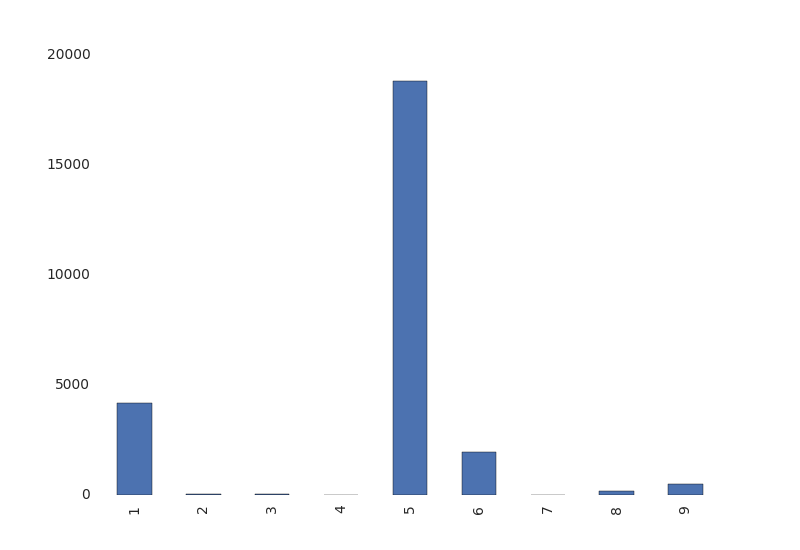

In [38]:
import matplotlib.pyplot as plt
plt.figure()
finalcount = topic_dist['doc'].value_counts().sort_index().plot(kind='bar')
display()